### Exercise 1 - Solution

In [ ]:
from numba import cuda
import numpy as np

@cuda.jit
def add_kernel(x, y, out):
    tidx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    bidx = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_dimx = cuda.blockDim.x  # number of threads per block
    grid_dimx = cuda.gridDim.x    # number of blocks in the grid
    
    start = tidx + bidx * block_dimx
    stride = block_dimx * grid_dimx

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]


n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out = out_device.copy_to_host()

### Exercise 2 - solution

In [ ]:
@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    
    # add code here
    
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    for i in range(start, x.shape[0], stride):
      bin_number = np.int32((x[i] - xmin)/bin_width)
      if bin_number >= 0 and bin_number < histogram_out.shape[0]:
        cuda.atomic.add(histogram_out, bin_number, 1)

In [ ]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

threads_per_block = 128
blocks_per_grid = 30
histogram_out = np.zeros(shape=10, dtype=np.int32)
cuda_histogram[blocks_per_grid, threads_per_block](x, xmin, xmax, histogram_out)

histogram_out

### Exercise 3 - solution

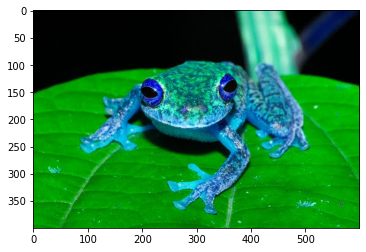

In [5]:
import cv2
import requests
import matplotlib.pyplot as plt

r = requests.get('https://static01.nyt.com/images/2019/04/02/science/28SCI-ZIMMER1/28SCI-ZIMMER1-articleLarge.jpg?quality=75&auto=webp&disable=upscale', allow_redirects=True)
open('frog.jpg', 'wb').write(r.content)

test_image = cv2.imread('frog.jpg')

plt.figure()
plt.imshow(test_image)

In [6]:
threadsperblock = 32
xblocks = (test_image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (test_image.shape[0] + (threadsperblock - 1)) // threadsperblock

print("Xblocks: ", xblocks)
print("Yblocks: ", yblocks)

Xblocks:  19
Yblocks:  13


In [7]:
from numba import cuda

@cuda.jit
def cv_histogram(image, grayscale_image):
    y,x = cuda.grid(2)
    
    if x < image.shape[0] and y < image.shape[1]:
        grayscale_image[x,y] = 0.2126*image[x,y,0] + 0.7152*image[x,y,1] + 0.0722*image[x,y,2]
    

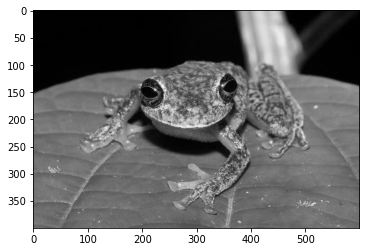

In [8]:
import numpy as np
import matplotlib.pyplot as plt

gray_img = np.zeros(shape=(test_image.shape[0], test_image.shape[1]), dtype=np.uint8)
# test_image = test_image.astype(np.uint32)

blocks_per_grid = (xblocks, yblocks)

cv_histogram[blocks_per_grid, (threadsperblock, threadsperblock)](test_image, gray_img)

plt.figure()
plt.imshow(gray_img, cmap='gray')